# Matemáticas para el tratamiento de datos
Autor: Adrián Robles Arques

Objetivo: Generar un algoritmo de recomendación de películas a usuarios basadas en similitudes entre las que ya han visto y le han gustado.


# 1. Leer datos desde Excel

Pandas dispone de funciones para leer datos desde formatos de tabla de datos, como xlsx, que es el caso. Dicha herramienta cuenta con la posibilidad de leer diversas hojas, o las hojas indicadas, dentro de la tabla de datos objetivo.

In [1]:
#Primero importamos las librerías necesarias
import pandas as pd
import numpy as np
import scipy as sp

#Importamos librerias para cargar datos en colab
from google.colab import files
import io

#librerías para escribir datos en documentos
from csv import writer

In [139]:
from os import name, rename
#Cargamos los datos desde local
uploaded = {}
uploaded = files.upload()

Saving plantilla_peliculas.xlsx to plantilla_peliculas.xlsx


El siguiente fragmento de código sirve para mantener el rastro del nombre del fichero con el que se sube al Colab, un problema habitual es que al ejecutar varias veces todas las celdas, una vez subido un fichero, la siguiente se sube con un nombre diferente por defecto, de esta forma se toma automáticamente el último nombre cargado y se emplea en la lectura de los datos.

In [140]:
#Leemos el nombre del archivo, por si se carga varias veces.
names = []
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  names.append(fn)

User uploaded file "plantilla_peliculas.xlsx" with length 203436 bytes


A continuación creamos el conjunto básico de dataframes con las 3 hojas del Excel que contienen los datos que vamos a procesar. Es importante saber que al usar la función de pandas `read_excel()` acepta una variable llamada `sheet_name = ` que por defecto es 0, y en la que se puede introducir tanto el índice de la hoja a la que queremos hacer referencia, como el nombre que se le haya dado en el Excel.

Ejemplo:


```
 pd.read_excel(open('tmp.xlsx', 'rb'),
             sheet_name=[0, 'Time_Data','Sheet3')  
```






In [141]:
#Creamos los DataFrames con las 3 primeras hojas
df_data = pd.read_excel(io.BytesIO(uploaded[names[0]]), sheet_name= [0,1,2])

Al leer desde excel varias entradas de hojas, se genera un diccionario que contiene cada hoja asociada con el nombre que se le da en el excel, por tanto para trabajar con los dataframes debemos separar los datos de cada hoja y tratarlos por separado.

In [142]:
#Separamos los diferentes Dataframes
df_movies = df_data[0]
df_ratings = df_data[1]
df_users = df_data[2][['userId', 'Género','Edad']]

In [143]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [144]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [145]:
df_users.head()

,userId,Género,Edad
0,1,H,29
1,3,M,24
2,4,M,29
3,5,H,32
4,6,M,18


Ahora vamos a analizar los géneros asociados a cada películas, a dividirlos y a codificarlos en forma one hot, para después poder hacer el análisis vectorial.

In [146]:
#Separamos los géneros en listas
df_movies['genres'] = df_movies['genres'].str.split('|')

In [147]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [148]:
#Hacemos la codificación one_hot manualmente dado que trabajamos con una lista de géneros

#Primero vamos a extraer la lista del total de géneros diferentes
genres_list = []
for index, row in df_movies.iterrows():
  for genre in row['genres']:
    if genre not in genres_list:
      genres_list.append(genre)

#Ahora vamos a iterar por género, comprobando si aparece en la lista de géneros de la película
for genre in genres_list:
  aux_list = []
  for index, row in df_movies.iterrows():
    aux_list.append(int(genre in row['genres']))
  df_movies[genre] = aux_list

df_movies.head()

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [149]:
df_movies.set_index('movieId', inplace=True)
df_movies.head()

,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary
movieId,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
2,Jumanji (1995),"[Adventure, Children, Fantasy]",1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0
5,Father of the Bride Part II (1995),[Comedy],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Vamos a escribir la representación vectorial en el excel

In [150]:
with pd.ExcelWriter(names[0],mode = 'a', if_sheet_exists = 'overlay') as writer:
  df_movies[genres_list].to_excel(writer, sheet_name = 'Representación vectorial')

Una vez realizado el tratamiento de los datos y la codificación como la queríamos, vamos a evaluar la similitud entre todas las películas, atendiendo al método del coseno. Para ello vamos a generar un vector unitario que codifique los géneros a los que pertence cada película y comprobaremos su cercanía al resto de películas para cada una de la lista.

In [151]:
#Vamos a generar los vectores unitarios para cada película

df_movies['vector_gen'] = df_movies[genres_list].values.tolist()
df_movies['vector_gen'] = df_movies['vector_gen'].apply(lambda x: np.array(x) / np.linalg.norm(x))

df_movies.head()

,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,vector_gen
movieId,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,"[0.4472135954999579, 0.4472135954999579, 0.447..."
2,Jumanji (1995),"[Adventure, Children, Fantasy]",1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,"[0.5773502691896258, 0.0, 0.5773502691896258, ..."
3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,"[0.0, 0.0, 0.0, 0.7071067811865475, 0.0, 0.707..."
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,"[0.0, 0.0, 0.0, 0.5773502691896258, 0.0, 0.577..."
5,Father of the Bride Part II (1995),[Comedy],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Vamos a escribir los vectores normalizados en el excel

In [152]:
#Creamos un nuevo dataframe con los vectores normalizados
df_norm_vectors = pd.DataFrame(df_movies['vector_gen'].tolist(), index=df_movies.index)
df_norm_vectors['norma'] = [np.linalg.norm(x) for x in
                            df_movies[genres_list].values.tolist()]

#Escribimos el resultado en la hoja correspondiente
with pd.ExcelWriter(names[0],mode = 'a', if_sheet_exists = 'overlay') as writer:
  df_norm_vectors.to_excel(writer, sheet_name = 'Normalización de vectores')

A continuación vamos a calcular la similitud de las peliculas entre si, usando para ello la regla del coseno. Dado que los vectores ya están normalizados, únicamente debemos calcular el producto vectorial entre todos los vectores asociados a cada película.

In [153]:
#Creamos un nuevo dataframe con los productos vectoriales de todos los vectores
product_dict = {}
for index, row in df_movies.iterrows():
  product_dict[index] = np.dot(row['vector_gen'], np.array(df_movies['vector_gen'].tolist()).T)

df_products = pd.DataFrame(product_dict, index=df_movies.index)
df_products.head()

,1,2,3,4,5,6,7,8,9,10,...,102,103,104,105,106,107,108,110,111,112
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.774597,0.316228,0.258199,0.447214,0.0,0.316228,0.632456,0.0,0.258199,...,0.447214,0.0,0.447214,0.000000,0.316228,0.670820,0.0,0.000000,0.000000,0.447214
2,0.774597,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.816497,0.0,0.333333,...,0.000000,0.0,0.000000,0.000000,0.000000,0.577350,0.0,0.000000,0.000000,0.288675
3,0.316228,0.000000,1.000000,0.816497,0.707107,0.0,1.000000,0.000000,0.0,0.000000,...,0.707107,0.0,0.707107,0.500000,0.500000,0.353553,0.0,0.000000,0.000000,0.353553
4,0.258199,0.000000,0.816497,1.000000,0.577350,0.0,0.816497,0.000000,0.0,0.000000,...,0.577350,0.0,0.577350,0.816497,0.816497,0.288675,0.0,0.333333,0.333333,0.288675
5,0.447214,0.000000,0.707107,0.577350,1.000000,0.0,0.707107,0.000000,0.0,0.000000,...,1.000000,0.0,1.000000,0.000000,0.707107,0.500000,0.0,0.000000,0.000000,0.500000


Vamos a escribir los resultados en el excel, para ello emplearemos las funciones de pandas ExcelWriter y to_excel.

In [154]:
with pd.ExcelWriter(names[0],mode = 'a', if_sheet_exists = 'overlay') as writer:
  df_products.to_excel(writer, sheet_name = 'Matriz de Similitudes (coseno)')

Teniendo ya la matriz de similitudes, necesitamos evaluar qué peliculas ha visto cada usuario y la puntiación atribuida a estas películas vistas, para poder predecir qué pelicula de las que no ha visto tiene más probabilidad de gustarle.

In [155]:
df_ratings.loc[df_ratings['userId'] == 1]

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0


In [156]:
#Vamos a definir una función que nos determine una predicción del score
#Esta función se basará en las peliculas vistas por cada usuario y la puntiación dada
#Así como la similitud de esta película con las demás

def pred_score(user_id, movie_id):
  df_user = df_ratings.loc[df_ratings['userId'] == user_id]
  if movie_id not in df_user['movieId'].tolist():
    p_score = 0.0
    for index, row in df_user.iterrows():
      p_score += row['rating'] * df_products.loc[movie_id][row['movieId']]
  else:
    p_score = 0.0 #Queremos que ignore películas ya vistas

  return p_score


In [157]:
#Prueba
pred_score(610, 1)

0.0

In [158]:
#Con la función elaborada, vamos a crear una matriz de predicciones por pelicula y usuario
userId_list = df_ratings['userId'].unique()
movieId_list = df_ratings['movieId'].unique()

#Generamos la matrix de datos
pred_list = []
for user in userId_list:
  pred_user = []
  for movie in movieId_list:
    pred = pred_score(user, movie)
    if pred == np.NaN:
      print('NaN')
    pred_user.append(pred)
  pred_list.append(pred_user)

#Convertimos datos a dataframe
df_pred = pd.DataFrame(pred_list, index=userId_list, columns= movieId_list)

In [159]:
df_pred.head()

,1,3,6,47,50,70,101,110,31,21,...,83,63,42,40,30,80,96,103,77,108
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.309401,15.325832,...,5.400760,11.535340,9.309401,2.309401,7.074995,2.897904,7.726331,9.615175,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.288675,0.000000,0.000000,...,0.353553,0.000000,0.288675,0.500000,0.353553,0.353553,0.353553,0.000000,0.0,0.0
4,4.363298,9.348469,4.483163,0.000000,5.966326,7.894823,7.476391,4.632993,8.024580,0.000000,...,8.123724,8.123724,5.632993,8.024580,6.898979,5.674235,12.573214,5.632993,0.0,0.0
5,0.000000,9.980387,8.299660,4.898979,0.000000,8.017265,11.675241,0.000000,10.853007,0.000000,...,11.215476,11.705132,11.898979,10.853007,12.940221,10.939146,14.113380,4.000000,0.0,0.0
6,37.558613,0.000000,0.000000,0.000000,0.000000,51.574509,49.413141,0.000000,0.000000,0.000000,...,63.609424,38.320092,59.454790,65.033600,56.338790,58.976431,73.952701,29.196444,0.0,0.0


In [160]:
df_pred.tail()

,1,3,6,47,50,70,101,110,31,21,...,83,63,42,40,30,80,96,103,77,108
606,0.0,28.775272,15.129682,0.000000,0.000000,0.000000,26.469639,0.0,33.105497,23.192554,...,38.037480,19.162900,26.697037,33.105497,28.425108,0.000000,37.556035,15.261314,0.0,0.0
607,0.0,5.921508,5.787694,0.000000,2.210343,5.358529,8.650479,0.0,13.999271,4.820489,...,12.623724,5.903869,13.870177,13.999271,12.606086,12.663891,13.095742,0.000000,0.0,0.0
608,0.0,0.000000,19.610410,0.000000,0.000000,0.000000,21.792819,0.0,0.000000,0.000000,...,13.815907,0.000000,18.350900,14.336126,17.127903,14.713012,24.966066,16.023423,0.0,0.0
609,0.0,0.948683,3.666667,1.632993,1.333333,3.846247,2.496341,0.0,1.732051,2.107930,...,1.224745,0.948683,3.333333,1.732051,1.224745,2.173428,2.173428,1.333333,0.0,0.0
610,0.0,4.409566,0.000000,0.000000,0.000000,0.000000,12.878873,0.0,8.666808,21.788155,...,6.128359,13.789256,19.305003,8.666808,15.508048,7.709498,10.537925,16.903850,0.0,0.0


Ahora vamos a añadir el dato del título de cada película, para ubicarla junto al userId y el movieId.

In [161]:
#Localizamos los títulos para cada Id
movie_titles = [df_movies.loc[movie]['title'] for movie in movieId_list]

dfpred = df_pred.T #Creamos un Df nuevo, así no perdemos el que únicamente tiene valores numéricos
dfpred['title'] = movie_titles
dfpred.head()

,1,3,4,5,6,7,8,9,11,12,...,602,603,604,605,606,607,608,609,610,title
1,0.0,0.0,4.363298,0.000000,37.558613,0.000000,8.210198,0.0,2.581989,1.264911,...,12.112357,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,Toy Story (1995)
3,0.0,0.0,9.348469,9.980387,0.000000,3.872515,7.898979,0.0,0.000000,4.000000,...,16.987428,28.361986,14.812644,3.264911,28.775272,5.921508,0.00000,0.948683,4.409566,Grumpier Old Men (1995)
6,0.0,0.0,4.483163,8.299660,0.000000,3.000000,10.966326,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,15.129682,5.787694,19.61041,3.666667,0.000000,Heat (1995)
47,0.0,0.0,0.000000,4.898979,0.000000,3.674235,0.000000,0.0,4.490731,0.000000,...,0.000000,11.844628,14.144815,0.000000,0.000000,0.000000,0.00000,1.632993,0.000000,Seven (a.k.a. Se7en) (1995)
50,0.0,0.0,5.966326,0.000000,0.000000,0.000000,0.000000,0.0,6.966326,0.000000,...,0.000000,23.179139,17.145157,0.000000,0.000000,2.210343,0.00000,1.333333,0.000000,"Usual Suspects, The (1995)"


Vamos a crear una función de recomendaciones que devuelva un DataFrame con el top X de películas a recomendar a cada usuario, con datos del título e Id de la película.

In [162]:
#Generamos la función de recomendación
def recommend(user_id, top = 10):
  recomendation = dfpred[[user_id, 'title']].sort_values(by = user_id,
                                                         ascending=False)[0:top]
  recomendation.columns = ['Score', 'Titulo']
  recomendation['MovieId'] = recomendation.index
  recomendation.index = ['Top ' + str(n) for n in
                         np.arange(1, len(recomendation) + 1)]

  return recomendation

# Top 10 recomendaciones para el UserId 4
recommend(4)

,Score,Titulo,MovieId
Top 1,12.573214,Big Bully (1996),75
Top 2,12.573214,Antonia's Line (Antonia) (1995),82
Top 3,12.573214,Kicking and Screaming (1995),72
Top 4,12.573214,In the Bleak Midwinter (1995),96
Top 5,12.265986,Beautiful Girls (1996),94
Top 6,12.265986,"American President, The (1995)",11
Top 7,12.265986,Waiting to Exhale (1995),4
Top 8,11.424642,Money Train (1995),20
Top 9,9.940221,City Hall (1996),100
Top 10,9.940221,"Juror, The (1996)",79


In [163]:
#Escribimos la recomendación en el excel
with pd.ExcelWriter(names[0],mode = 'a', if_sheet_exists = 'overlay') as writer:
  recommend(4).to_excel(writer, sheet_name = 'Recomendaciones', startrow= 1)

# Fase 2: Estadística descriptiva

En esta fase deberemos analizar los ratings por usuario y extraer una serie de datos estadísticos por usuario.

userId --> Rating medio, Rating max, Rating min, Rango.

Después deberemos obtener una lista de los usuarios con mayor rango de rating, ordenados.

A continuación, obtendremos la varianza y desviación típica del promedio de ratings. Y crearemos un gráfico de cajas para el rating medio, así como de la edad, señalando y tratando los outliers sustituyéndolos por la mediana de la variable.

Luego haremos un histograma de la variable edad, calcularemos las frecuencias absolutas de hombres y mujeres, haremos un gráfico de barras de la variable género, así como un gráfico de dispersión para el rating medio y la edad.

Calcularemos la correlación entre el rating medio, el rango de rating y la edad,

In [164]:
#Agrupamos el dataframe por userId y tomamos los rating para calcular la media
rating_mean = df_ratings[['userId', 'rating']].groupby('userId').mean()
rating_max = df_ratings[['userId', 'rating']].groupby('userId').max()
rating_min = df_ratings[['userId', 'rating']].groupby('userId').min()
rating_range = pd.DataFrame(rating_max['rating'] - rating_min['rating'])

stat_rating = pd.concat([rating_mean, rating_max, rating_min, rating_range], axis=1)
stat_rating.columns = ['Rating medio', 'Rating máximo', 'Rating mínimo', 'Rango']
stat_rating.head()

,Rating medio,Rating máximo,Rating mínimo,Rango
userId,,,,
1,4.250000,5.0,3.0,2.0
3,0.500000,0.5,0.5,0.0
4,2.857143,4.0,2.0,2.0
5,4.000000,5.0,3.0,2.0
6,3.607843,5.0,1.0,4.0


Vamos a listar los usuarios por orden de Rango

In [165]:
#Después de habernos aseguridado de que rating_range es un DF podemos hacer esto
rating_range['userId'] = rating_range.index
rating_range.columns = ['Rango', 'userId']

In [166]:
#Calculamos la varianza y desviación típica de los promedios de rating
var_rat_med = rating_mean.var()
dst_rat_med = rating_mean.std()

disp_rating = pd.DataFrame([var_rat_med, dst_rat_med], index= ['Varianza', 'Desviación típica'])
disp_rating.columns = ['Rating medio']
disp_rating

,Rating medio
Varianza,0.548738
Desviación típica,0.740769


In [167]:
#Calculamos el mayor valor del rango (columna 10, fila 27)
rango_max = rating_range['Rango'].max()
rango_max

#Los usuarios con mayor rango quiere decir que marquemos los usuarios con este valor de rango
stat_rating['Rango max'] = [True if x == rango_max else False for x in rating_range['Rango']]

stat_rating.head()

,Rating medio,Rating máximo,Rating mínimo,Rango,Rango max
userId,,,,,
1,4.250000,5.0,3.0,2.0,False
3,0.500000,0.5,0.5,0.0,False
4,2.857143,4.0,2.0,2.0,False
5,4.000000,5.0,3.0,2.0,False
6,3.607843,5.0,1.0,4.0,False


In [186]:
#Frecuencia de usuarios por género
genero_counts = df_users['Género'].value_counts()
df_genero_c = pd.DataFrame(genero_counts.values.reshape(1,-1), columns= genero_counts.index)
df_genero_c

Género,M,H
0,284,245


In [169]:
df_users.head()

,userId,Género,Edad
0,1,H,29
1,3,M,24
2,4,M,29
3,5,H,32
4,6,M,18


In [170]:
#Creamos un dataframe para los usuarios con información ampliada
df_users_amp = stat_rating.merge(df_users, on='userId')
df_users_amp.set_index('userId', inplace=True)
df_users_amp.head()

,Rating medio,Rating máximo,Rating mínimo,Rango,Rango max,Género,Edad
userId,,,,,,,
1,4.250000,5.0,3.0,2.0,False,H,29
3,0.500000,0.5,0.5,0.0,False,M,24
4,2.857143,4.0,2.0,2.0,False,M,29
5,4.000000,5.0,3.0,2.0,False,H,32
6,3.607843,5.0,1.0,4.0,False,M,18


In [171]:
#Calculamos la correlación entre rating medio y edad
corr_rating_edad = df_users_amp['Rating medio'].corr(df_users_amp['Edad'])

#Calculamos la correlación entre rango del rating y edad
corr_range_edad = df_users_amp['Rango'].corr(df_users_amp['Edad'])

df_corr = pd.DataFrame([corr_rating_edad, corr_range_edad], index= ['Rating medio y edad', 'Rango y edad'])
df_corr.columns = ['Correlación']
df_corr

,Correlación
Rating medio y edad,0.467638
Rango y edad,-0.154890


In [172]:
#Calculamos la matriz de correlaciones entre películas
corr_matrix = []
for movieX in df_movies['vector_gen']:
  line_mat = []
  for movieY in df_movies['vector_gen']:
    line_mat.append(np.corrcoef(movieX, movieY)[0][1])
  corr_matrix.append(line_mat)

corr_matrix = pd.DataFrame(corr_matrix, index=df_movies.index, columns=df_movies.index)
corr_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,102,103,104,105,106,107,108,110,111,112
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.712525,0.152894,0.021592,0.382971,-0.323875,0.152894,0.560612,-0.174078,0.021592,...,0.382971,-0.323875,0.382971,-0.254824,0.152894,0.544949,-0.174078,-0.323875,-0.323875,0.233550
2,0.712525,1.000000,-0.181568,-0.230769,-0.124035,-0.230769,-0.181568,0.786796,-0.124035,0.179487,...,-0.124035,-0.230769,-0.124035,-0.181568,-0.181568,0.462250,-0.124035,-0.230769,-0.230769,0.092450
3,0.152894,-0.181568,1.000000,0.786796,0.683130,-0.181568,1.000000,-0.142857,-0.097590,-0.181568,...,0.683130,-0.181568,0.683130,0.428571,0.428571,0.218218,-0.097590,-0.181568,-0.181568,0.218218
4,0.021592,-0.230769,0.786796,1.000000,0.537484,-0.230769,0.786796,-0.181568,-0.124035,-0.230769,...,0.537484,-0.230769,0.537484,0.786796,0.786796,0.092450,-0.124035,0.179487,0.179487,0.092450
5,0.382971,-0.124035,0.683130,0.537484,1.000000,-0.124035,0.683130,-0.097590,-0.066667,-0.124035,...,1.000000,-0.124035,1.000000,-0.097590,0.683130,0.447214,-0.066667,-0.124035,-0.124035,0.447214


Ahora escribimos el resultado en el excel

In [187]:
#Abrimos la herramienta de escritura y la configuramos
with pd.ExcelWriter(names[0],mode = 'a', if_sheet_exists = 'overlay') as writer:

#Escribimos la matriz de correlaciones en la hoja pertinente, sin escribir índices
  corr_matrix.to_excel(writer, sheet_name = 'Matriz de Similitudes (corr.)',
                       index= False, header= False, startrow= 1, startcol= 1)

#Escribimos los estadísticos sin mostrar los ID otra vez (col 3)
  stat_rating.to_excel(writer, sheet_name = 'Usuarios', startcol= 3, index= False)

#Escribimos la varianza y desviación típica del rating medio
  disp_rating.to_excel(writer, sheet_name = 'Usuarios', startcol= 10, startrow= 1,
                       index= False, header= False)

#Escribimos le valor máximo del rango, lo tratamos como DF para poder manipularlo bien
  pd.DataFrame(rating_range.max()).T.to_excel(writer, sheet_name = 'Usuarios' ,
                                  columns= ['Rango'], startcol= 10,
                                  startrow= 27, index= False, header= False)

#Escribimos la frecuencia de usuarios por género ( Col 11, Filas 40 y 41)
  df_genero_c.to_excel(writer, sheet_name = 'Usuarios', columns= ['H'],
                                             startcol= 11, startrow= 40,
                                             index= False, header= False)
  df_genero_c.to_excel(writer, sheet_name = 'Usuarios',  columns= ['M'],
                                             startcol= 11, startrow= 41,
                                             index= False, header= False)

# Escribimos los valores de correlaciones que nos piden (Col 10, Fila 65)
  df_corr.to_excel(writer, sheet_name = 'Usuarios', startcol= 10, startrow= 65,
                   index= False, header= False)



### Generación de gráficos

El ejercicio también nos pide una serie de gráficos en la parte 2:



*   Grafico de caja del rating medio
*   Grafico de caja de la edad, anclando outliers a la mediana (En este caso outlier == valor erróneo)
*  Histograma de la edad
*  Grafico de barras del Género
*  Grafico de dispersión entre rating medio y edad



In [188]:
#Importamos las librerias gráficas
import matplotlib.pyplot as plt
import seaborn as sns

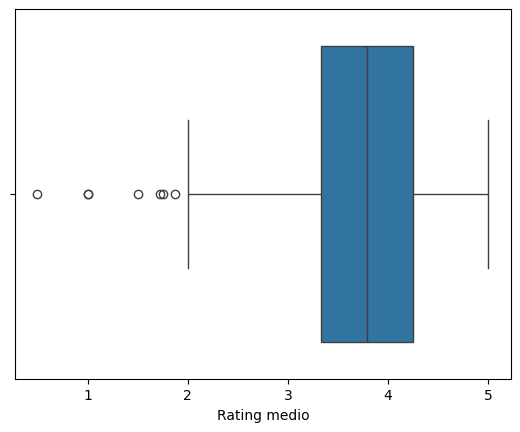

3.7440760178582346

In [189]:
#Grafico de cajas del rating medio
sns.boxplot(x= stat_rating['Rating medio'])
plt.show()
stat_rating['Rating medio'].mean()

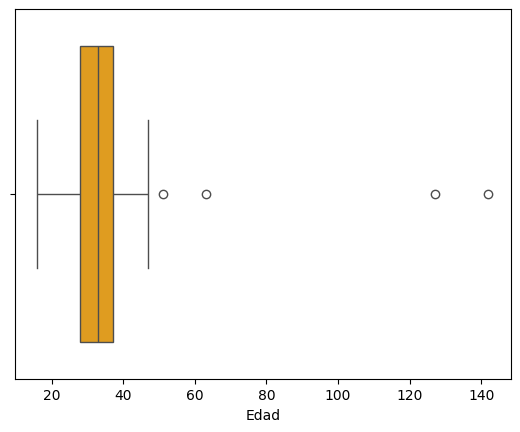

In [190]:
#Grafico de cajas de la edad
sns.boxplot(x= df_users_amp['Edad'], color= 'orange')
plt.show()

In [191]:
edadQ1 = df_users_amp['Edad'].quantile(0.25)
edadQ3 = df_users_amp['Edad'].quantile(0.75)
edadM = df_users_amp['Edad'].median()
edadIQR = edadQ3 - edadQ1
df_users_amp.loc[df_users_amp['Edad'] > edadM + 1.5 * edadIQR]

,Rating medio,Rating máximo,Rating mínimo,Rango,Rango max,Género,Edad
userId,,,,,,,
22,4.500000,4.5,4.5,0.0,False,M,51
62,4.375000,4.5,4.0,0.5,False,H,63
145,4.666667,5.0,4.0,1.0,False,H,47
352,5.000000,5.0,5.0,0.0,False,M,47
353,3.888889,5.0,1.0,4.0,False,M,127
437,3.409091,5.0,1.0,4.0,False,M,142


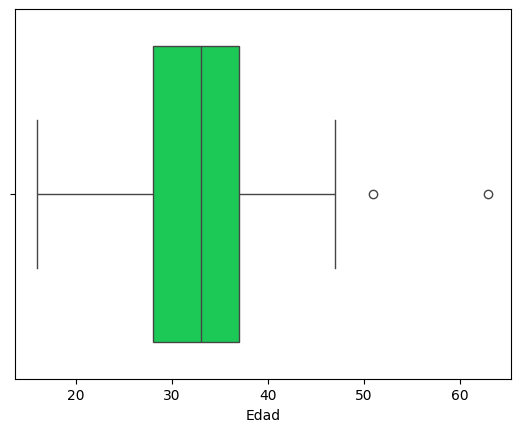

In [192]:
#Aparecen varios valores demasiado elevados, tomaremos como outliers x>80
df_users_amp['Edad'] = [x if x < 80 else df_users_amp['Edad'].median() for x in df_users_amp['Edad']]

sns.boxplot(x= df_users_amp['Edad'], color = (0,0.9,0.3))
plt.show()

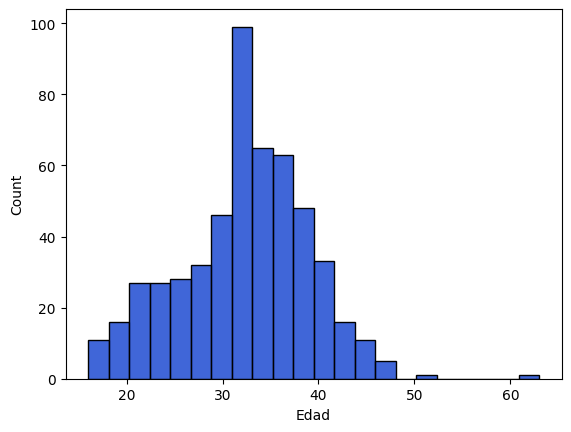

In [193]:
#Histograma de la edad
sns.histplot(x= df_users_amp['Edad'], color= (0,0.2,0.8))
plt.show()

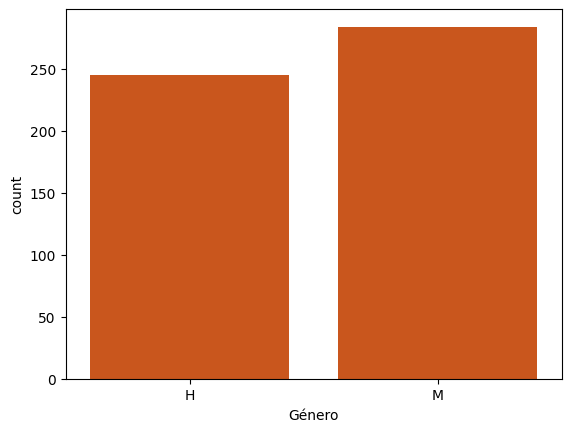

In [194]:
#Grafico de barras de género
sns.countplot(x= df_users_amp['Género'], color= (0.9,0.3,0))
plt.show()

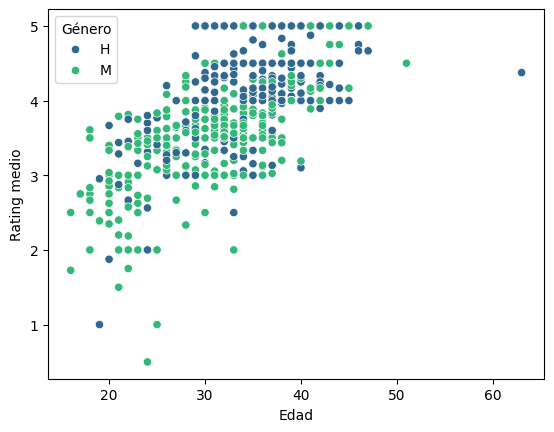

In [195]:
#Gráfico de dispersión entre rating medio y edad
sns.scatterplot(data= df_users_amp, x= 'Edad', y= 'Rating medio',
                hue = 'Género', palette = 'viridis')
plt.show()

# FASE 3: Estadística inferencial

Ejercicios de esta fase:


1.  Probabilidad de que un usuario al azar sea hombre
2.  Aproxima la distribución de probabilidad de la edad de los usuarios con una distribución normal (¿Qué valor va aquí?)
3. Probabilidad de que la edad esté comprendida entre 35 y 40 años (Después de aproximar a la distribución normal)
4. ¿La correlación entre la edad y la nota media es significativa?
5. Obten la recta de regresión que relacione la edad de los usuarios y su rating medio.
6. ¿Qué rating medio se estima que darían los usuarios de 60 años?



In [196]:
genero_counts

,count
Género,
M,284
H,245


In [197]:
#Probabilidad de usuario al azar de ser hombre
p_hombre = genero_counts.loc['H'] / genero_counts.sum()
p_hombre

0.46313799621928164

In [198]:
#Aproximar la probabilidad de la edad de los usuarios a una distribución normal
mean_edad = df_users_amp['Edad'].mean()
std_edad = df_users_amp['Edad'].std()

#generamos distribución normal con los datos anteriores
dist_normal = sp.stats.norm(mean_edad, std_edad)
dist_simul = dist_normal.rvs(size= len(df_users_amp['Edad']))

DistN_Edad = pd.DataFrame(['N({},{})'.format(round(mean_edad,2),round(std_edad,2))], columns = ['Distribución'])
DistN_Edad.index = ['Edad']
DistN_Edad

,Distribución
Edad,"N(32.25,6.66)"


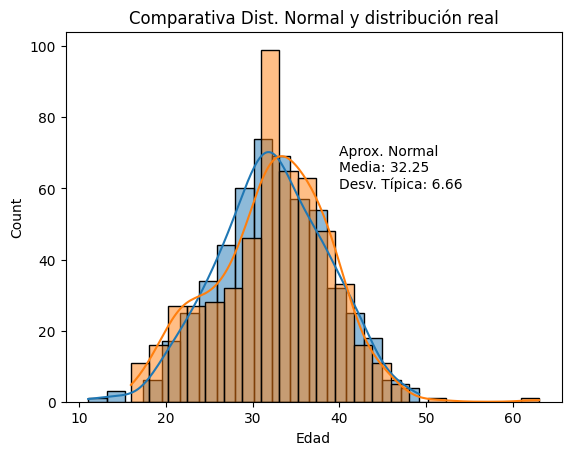

In [199]:
#Graficamos el resultado
sns.histplot(dist_simul, kde= True)
plt.text(40,60,'Aprox. Normal \nMedia: {}\nDesv. Típica: {}'.format(round(mean_edad,2)
         ,round(std_edad,2)))
sns.histplot(df_users_amp['Edad'], kde= True)
plt.title('Comparativa Dist. Normal y distribución real')
plt.show()

Hallamos la probabilidad de que un usuario tenga una edad comprendida entre 35 y 40 años

In [200]:
#Vamos a usar la cumulative density function incluida en scipy
P_35_40 = dist_normal.cdf(40) - dist_normal.cdf(35)
P_35_40

0.21743419432988143

¿La correlación entre la edad y la nota media es significativa? Para ello debemos calcular el estadístico p o p-valor.

Recordatorio: El estadístico t correspondiente a una distribución T-student es el que marca el valor límite para nuestro intervalo de confianza, a partir del cual calcularemos el área que determina el p-valor. Asumimos una distribución T-student cuando no conocemos la desviación poblacional.

In [201]:
#Importamos la función de correlación desde scipy
from scipy.stats import pearsonr

#Esta función devuelve una tupla que contiene el valor de correlación y el p-valor
# para los dos arrays introducidos --> pearson(X,Y) = (corr, p-valor)

df_corr_edad_rat = pd.DataFrame(pearsonr(df_users_amp['Edad'], df_users_amp['Rating medio']))
df_corr_edad_rat.columns = ['Valor']
df_corr_edad_rat.index = ['Correlación', 'p-valor']
df_corr_edad_rat

,Valor
Correlación,6.521884e-01
p-valor,2.129220e-65


Generamos un modelo de regresión lineal para la edad y el rating de los usuarios

*   X = Edad
*   Y = Rating

Calculamos $W = (X^T X)^{-1}X^TY $


In [208]:
#Calculamos el R2 de la recta
from sklearn.metrics import r2_score
R2 = r2_score(y, X @ w)

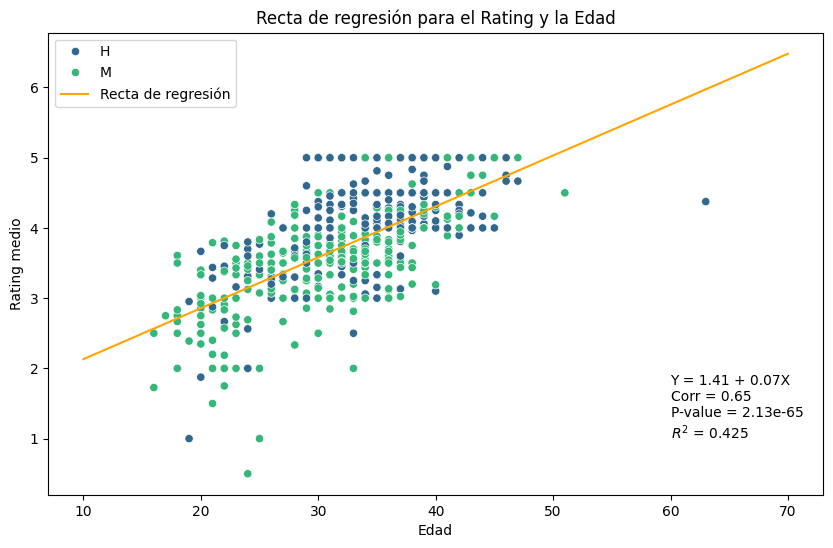

In [211]:
# Preparamos los datos
x = df_users_amp['Edad']
y = df_users_amp['Rating medio']

#Transformamos los datos en arrays
x = x.to_numpy()
y = y.to_numpy()

X = np.concatenate((np.ones(len(x)).reshape(1,529), x.reshape(1,529)), axis = 0).T
Y = y.reshape(1,529).T

#Calculamos los coeficientes
w = np.linalg.inv(X.T @ X) @ X.T @ Y

#Por ende la recta será Y = w0 + w1*X
#Representamos con seaborn
X_1 = np.linspace(10,70)
Y_1 = w[0] + w[1] * X_1

plt.figure(figsize=(10,6))
sns.scatterplot(data= df_users_amp, x= 'Edad', y= 'Rating medio',
                hue = 'Género', palette = 'viridis')
sns.lineplot(x= X_1, y= Y_1, color= 'orange', label = 'Recta de regresión')
plt.title('Recta de regresión para el Rating y la Edad')
plt.text(60,1,'Y = {:.2f} + {:.2f}X \nCorr = {:.2f} \nP-value = {:.2e} \n$R^2$ = {:.3f}'.format(w[0][0],
                            w[1][0], df_corr_edad_rat['Valor']['Correlación'],
                            df_corr_edad_rat['Valor']['p-valor'], R2))
plt.show()

¿Qué rating medio se estima que daría un usuario de 60 años?

In [203]:
#Utilizamos la ecuación de la recta para evaluar Y
Y_60 = w[0] + w[1] * 60
Y_60

array([5.75575632])

Ahora escribimos los resultados en el Excel

In [204]:
#Abrimos la herramienta de escritura y la configuramos
with pd.ExcelWriter( names[0] ,mode = 'a', if_sheet_exists = 'overlay') as writer:

#P(H) (columna 10, fila 85)
  pd.DataFrame([p_hombre]).to_excel(writer, sheet_name = 'Usuarios',
                                    startcol= 10, startrow= 85,
                                    index= False, header= False)

# Distribución normal de la edad (columna 10, fila 87)
  DistN_Edad.to_excel(writer, sheet_name = 'Usuarios', startcol = 10, startrow = 87,
                      index= False, header= False)

#P(35-40) (columna 10, fila 90)
  pd.DataFrame([P_35_40]).to_excel(writer, sheet_name = 'Usuarios',
                                    startcol= 10, startrow= 90,
                                    index= False, header= False)

#Introducimos el valor de significancia (p-valor) (columna 10, fila 93)
  df_corr_edad_rat.T.to_excel(writer, columns= ['p-valor'], sheet_name = 'Usuarios', startcol= 10, startrow= 93,
                            index= False, header= False)

#Introducimos la recta con su valor en la hoja correspondiente (columna 10, fila 95)
  pd.DataFrame(['Y = {:.2f} + {:.2f}X'.format(w[0][0], w[1][0])], columns= ['Recta regresion']
               ).T.to_excel(writer, sheet_name = 'Usuarios',
                                    startcol= 10, startrow= 95,
                                    index= False, header= False)

#Introducimos el valor de la predicción para 60 años (columna 10, fila 108)
  pd.DataFrame([Y_60]).to_excel(writer, sheet_name = 'Usuarios',
                                    startcol= 10, startrow= 108,
                                    index= False, header= False)

Por último, descargamos el excel escrito

In [205]:
files.download(names[0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>